## 1.Import Libraries

In [44]:
import os
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import random
import cv2
import timm
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from torch.nn import functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

## 2. Extract Data from XML and Store in New Folder

### 2.1 Extract
Trích xuất dữ liệu từ file words.xml trong bộ IC03
Hàm này dùng để trích các thông tin từ file .xml bao gồm: `(image paths, image sizes, image labels và bboxes)`

In [45]:
def extract_dataset_from_xml(root_dir):
    
    # Create path to file words.xml
    xml_path = os.path.join(root_dir, 'words.xml')
    # Parse file xml
    tree = ET.parse(xml_path)
    # Read root of file
    root = tree.getroot()

    # Create lists to save data 
    img_paths = []
    img_sizes = []
    img_labels = []
    bboxes = []

    for img in root:
        bbs_of_img = []
        labels_of_img = []

        for bbs in img.findall('taggedRectangles'):
            for bb in bbs:
                # Skip labels aren't alphabet or number
                if not bb[0].text.isalnum():
                    continue
                    
                # Skip labels have 'é' hoặc 'ñ'
                if 'é' in bb[0].text.lower() or 'ñ' in bb[0].text.lower():
                    continue

                # Push infomation of bbox in bboxes_of_img 
                # YOLO format:(x_center, y_center, bbox_width, bbox_height)
                bbs_of_img.append(
                    [
                        float(bb.attrib['x']), 
                        float(bb.attrib['y']), 
                        float(bb.attrib['width']), 
                        float(bb.attrib['height'])
                    ]
                )
                # Push lable to labels_of_img
                labels_of_img.append(bb[0].text.lower())
                
        # Push infomation path of img to imgs_path
        img_path = os.path.join(root_dir, img[0].text)
        img_paths.append(img_path)
        # Push infomation size of img to img_sizes
        img_sizes.append((int(img[1].attrib['x']), int(img[1].attrib['y'])))
        # Push bbox to list bboxes 
        bboxes.append(bbs_of_img)
        # Push labels to img_labels
        img_labels.append(labels_of_img)

    return img_paths, img_sizes, img_labels, bboxes            

In [46]:
dataset_dir = 'datasets/SceneTrialTrain'
img_paths, img_sizes, img_labels, bboxes = extract_dataset_from_xml(dataset_dir)

print(f"Total images: {len(img_paths)}")
print(f"Total bounding boxes: {sum([len(bbs) for bbs in bboxes])}")

Total images: 250
Total bounding boxes: 1097


###  Plot an example

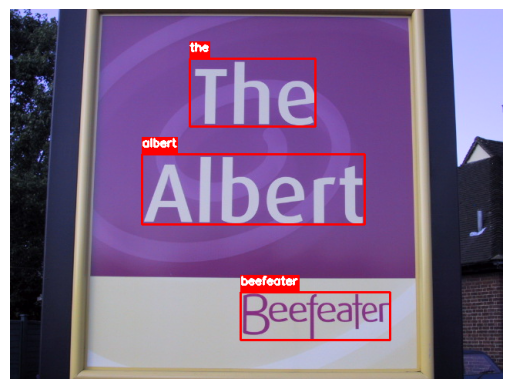

In [47]:
def plot_image_with_bboxes(img_path, bboxes, img_labels):
    
    # Read Image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for idx, bbox in enumerate(bboxes):
        # Draw bounding box
        start_point = (int(bbox[0]), int(bbox[1]))
        end_point = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        color = (255, 0, 0)
        thickness = 2
        img = cv2.rectangle(img, start_point, end_point, color, thickness)
        
        # Print labels in bouding box
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_color = (255, 255, 255)
        line_type = 2
        text_thickness = 2
        label = img_labels[idx]
        text_size, _ = cv2.getTextSize(label, font, font_scale, thickness)
        
        # Draw bounding box for labels
        label_background_start = (int(bbox[0]), int(bbox[1]- text_size[1]-10))
        label_background_end = (int(bbox[0] + text_size[0]), int(bbox[1]))
        img = cv2.rectangle(img, label_background_start, label_background_end, color, cv2.FILLED)
        
        cv2.putText(img, 
                    label, 
                    (int(bbox[0]), int(bbox[1]-10)),
                    font, 
                    font_scale, 
                    font_color, 
                    text_thickness, 
                    line_type)
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Random an image 
i = random.randint(0, len(img_paths))
plot_image_with_bboxes(img_paths[i], bboxes[i], img_labels[i])   

### 2.2 Store all bounding boxes as a new dataset

In [54]:
def split_bounding_boxes(img_paths, img_labels, bboxes, save_dir):
    # Create folder store data 
    os.makedirs(save_dir, exist_ok=True)
    
    count = 0
    labels = []
    for img_path, img_label, bbs in zip(img_paths, img_labels, bboxes):
        # Read Image
        img = Image.open(img_path)
        
        for label, bb in zip(img_label, bbs):
            # Crop Image
            cropped_img = img.crop((bb[0], 
                                    bb[1],
                                    bb[0] + bb[2],
                                    bb[1] + bb[3]))
            # Skip crop image have 90% white or black
            if np.mean(cropped_img) < 35 or np.mean(cropped_img) > 220:
                continue
            
            # Skip crop image have width < 10 or height < 10
            if cropped_img.size[0] < 10 or cropped_img.size[1] < 10:
                continue
            
            # Skip if number of label < 3
            if len(label) < 3:
                continue
                
            # Create file anf save
            file_name = f"{count:06d}.jpg"
            cropped_img.save(os.path.join(save_dir, file_name))
            new_img_path = os.path.join(save_dir, file_name)
            
            # Push format label to list labels (img_path\tlabel)
            label = new_img_path + '\t' + label
            labels.append(label)
            count += 1
    print(f"Created {count} images")
    
    with open(os.path.join(save_dir, 'new_labels.txt'), 'w') as file:
        for label in labels:
            file.write(f"{label}\n")

In [55]:
save_dir = 'datasets/ocr_dataset'
split_bounding_boxes(img_paths, img_labels, bboxes, save_dir)

Created 928 images


## 3. Read dataset

In [57]:
root_dir = save_dir
img_paths = []
labels = []

with open(os.path.join(root_dir, 'new_labels.txt'), 'r') as file:
    for label in file:
        labels.append(label.strip().split('\t')[1])
        img_paths.append(label.strip().split('\t')[0])
print(f"total Images: {len(img_paths)}")

total Images: 928


## 4. Build Vocabulary

In [58]:
# Take all char in labels
letters = [char.split(".")[0].lower() for char in labels]
letters = "".join(letters)

# Filter same char
letters = sorted(list(set(list(letters))))

# Convert list char to string
chars = "".join(letters)

# Add blank("-") to vocab
blank_char = '-'
chars += blank_char

# Calculate size of vocab
vocab_size = len(chars)

print("Vocab: ", chars)
print("Vocab_size: ", vocab_size)

Vocab:  0123456789abcdefghijklmnopqrstuvwxyz-
Vocab_size:  37


**Create dictionary to convert `char to idx` and `idx to char`**

In [62]:
char_to_idx = {char: idx+1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}
print(char_to_idx.items())

dict_items([('-', 1), ('0', 2), ('1', 3), ('2', 4), ('3', 5), ('4', 6), ('5', 7), ('6', 8), ('7', 9), ('8', 10), ('9', 11), ('a', 12), ('b', 13), ('c', 14), ('d', 15), ('e', 16), ('f', 17), ('g', 18), ('h', 19), ('i', 20), ('j', 21), ('k', 22), ('l', 23), ('m', 24), ('n', 25), ('o', 26), ('p', 27), ('q', 28), ('r', 29), ('s', 30), ('t', 31), ('u', 32), ('v', 33), ('w', 34), ('x', 35), ('y', 36), ('z', 37)])


**Calculate max_label_len to create `padding`**

In [64]:
max_label_len = max([len(label) for label in labels])
print("Max_word_len: ", max_label_len)

Max_word_len:  14


## 5. Create data preprocessing function

### 5.1 Encode
Encode label to `tensor` 

In [100]:
def encode(label, char_to_idx, max_label_len):
    # Convert to Tensor
    encoded_labels = torch.tensor(
                    [char_to_idx[char] for char in label], dtype = torch.long)
    
    # Calculate len of label
    label_len = len(encoded_labels)
    lengths = torch.tensor(label_len, dtype = torch.long)
    
    # Padding
    padded_labels = F.pad(encoded_labels, 
                          (0, max_label_len - label_len), value = 0)
    return padded_labels, lengths

### 5.2 Decode
Decode encoded label to `string`

In [110]:
def decode(encoded_sequences, idx_to_char, blank_char = "-"):
    # Creat list result decode
    decoded_sequences = []
    
    for seq in encoded_sequences:
        # Create list contain any char was decode
        decoded_label = []
        
        for idx, token in enumerate(seq):
            # Skip token padding (idx = 0)
            if token != 0:
                char = idx_to_char[token.item()] # because data is tensor
                # Skip black char "-"
                if char != blank_char:
                    decoded_label.append(char)
        # Add to decoded_sequences
        decoded_sequences.append("".join(decoded_label))
    return decoded_sequences

In [111]:
# Create transform function
data_transforms ={
    'train': transforms.Compose([transforms.Resize((32, 100)),
                            transforms.ColorJitter(
                                brightness = 0.5, contrast = 0.5, saturation = 0.5),
                            transforms.Grayscale(num_output_channels =1),
                            transforms.GaussianBlur(3),
                            transforms.RandomAffine(degrees = 2, shear = 2),
                            transforms.RandomPerspective(distortion_scale = 0.4,
                                                           p = 0.5,
                                                           interpolation = 3),
                            transforms.RandomRotation(degrees = 2),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,), (0.5,))]),
    'val' : transforms.Compose([
        transforms.Resize((32, 100)), 
        transforms.Grayscale(num_output_channels = 1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
}

## 6. Train, Val, Test split

In [112]:
seed = 0
val_size = 0.2
test_size = 0.1
X_train, X_val , y_train, y_val = train_test_split(img_paths, labels, 
                                        test_size = val_size, random_state = seed,
                                        shuffle = True)
X_train, X_test , y_train, y_test = train_test_split(img_paths, labels,
                                        test_size = test_size, random_state = seed,
                                        shuffle= True)

## 7. Create Pytorch dataset

In [113]:
class STRDataset(Dataset):
    def __init__(self, X, y, char_to_idx, max_label_len, 
                 label_encoder = None, transform = None):
        self.img_paths = X
        self.labels = y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder
        self.transform = transform
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(label, 
                                                         self.char_to_idx,
                                                         self.max_label_len)
        return img, encoded_label, label_len

## 8. Create DataLoader

In [114]:
train_dataset = STRDataset(X_train, y_train,
                           char_to_idx = char_to_idx,
                           max_label_len = max_label_len, 
                           label_encoder = encode,
                           transform = data_transforms['train'])
val_dataset = STRDataset(X_val, y_val,
                           char_to_idx = char_to_idx,
                           max_label_len = max_label_len, 
                           label_encoder = encode,
                           transform = data_transforms['val'])
test_dataset = STRDataset(X_test, y_test,
                           char_to_idx = char_to_idx,
                           max_label_len = max_label_len, 
                           label_encoder = encode,
                           transform = data_transforms['val'])

In [115]:
print("Train dataset: ", len(train_dataset))
print("Val dataset: ", len(val_dataset))
print("Test dataset: ", len(test_dataset))

Train dataset:  835
Val dataset:  186
Test dataset:  93


In [116]:
train_batch_size = 256
test_batch_size = 10

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)


In [125]:
train_features, train_labels, train_lengths = next(iter(train_loader))

# Use torchvision to display a grid of images
def show_batch(imgs, labels):
    labels = decode(labels, idx_to_char)
    grid = torchvision.utils.make_grid(imgs, nrow = 4, normalize = True)
    plt.figure(figsize = (10, 20))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print(labels)
    plt.show()

['not', 'a134', 'lager', 'updates', 'leisure', 'fluoride', 'coleman', 'with', 'caution', 'orange', 'frank', 'the', 'the', 'publishing', 'london', 'monument', 'powershot', 'communication', 'written', 'push', 'tan', 'system', 'heart', 'intelligence', 'service', 'mexican', 'order', 'photo', 'here', 'edition', 'and', 'licensed', 'here', 'his', 'genie', 'seatrade', 'eaton', 'office', 'coke', 'when', 'norvig', 'web', 'ipswich', 'council', 'town', 'publication', 'hall', 'cooling', 'ales', 'vodka', 'flying', 'spirits', 'folders', 'roll', 'station', 'barclays', 'appreciate', 'bostock', 'spencer', 'case', 'cities', 'cigarettes', 'toilet', 'not', 'live', 'espmoto', 'clacton', 'registered', 'freephone', 'multimedia', 'allende', 'town', 'wroxcom', 'nokia', 'franklin', 'discover', 'ahead', 'edition', 'garden', 'stationery', 'arena', 'commonwealth', 'section', 'building', 'car', '115mm', 'need', 'you', 'hire', 'care', 'will', 'cable', 'chelmsford', 'exit', 'royal', 'estate', 'pentium', 'inspiron', 'a

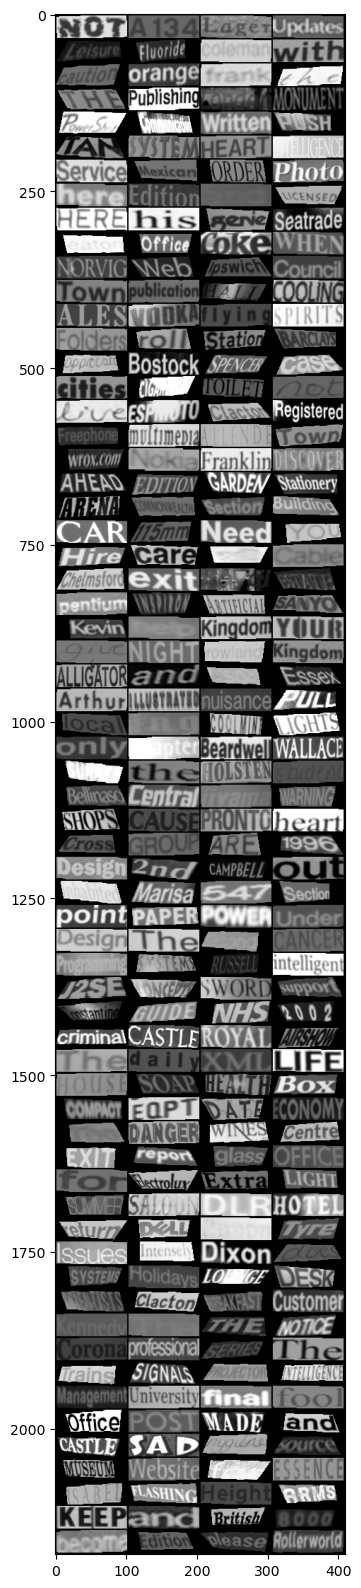

In [126]:
show_batch(train_features, train_labels)

## 9. Create Model
<img src="image.png">

In [153]:
class CRNN(nn.Module):
    def __init__(self, in_channels,
                vocab_size,
                hidden_size,
                n_layers,
                dropout = 0.2):
        super(CRNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), (2, 1), (0, 1)))
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), (2, 1), (0, 1)))
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size = 2, stride = 1, padding = 0),
            nn.ReLU(inplace=True))
        self.mapSeq = nn.Linear(512, 64)
        self.lstm = nn.LSTM(64, hidden_size, num_layers = n_layers,
                                   bidirectional = True, dropout = dropout if n_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Sequential(
                    nn.Linear(hidden_size*2, vocab_size),
                    nn.LogSoftmax(dim = 2))
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        
        x = self.conv3(x)        
        x = self.conv4(x)
        x = self.conv5(x)
        
        batch, channel, height, width = x.size()
        x =  x.view(batch, channel * height, width)
        x = x.permute(2, 0, 1)
        x = self.mapSeq(x)
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.out(x)
        
        return x

In [154]:
in_channels = 1
hidden_size = 256
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CRNN(in_channels = in_channels,
            vocab_size = vocab_size,
            hidden_size = hidden_size,
            n_layers = n_layers,
            dropout = dropout_prob).to(device)

In [155]:
model.eval()

CRNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Con

In [156]:
# 64: batch
# 1: channel
# 32: height
# 100: width
dummy_tensor = torch.rand((64, 1, 32, 100)).to(device)
with torch.no_grad():
    output = model(dummy_tensor)
print("Output shape: ", output.shape)

Output shape:  torch.Size([26, 64, 37])


## 10. Training

### 10.1 Evaluate

In [157]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for inputs, labels, labels_len in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)            
            labels_len = labels_len.to(device)            
            
            outputs = model(inputs)
            # Calculate len of model outputs
            logits_lens = torch.full(size = (outputs.size(1),),
                                    fill_value = outputs.size(0),
                                    dtype = torch.long).to(device)
            loss = criterion(outputs, labels, logits_lens, labels_len)
            losses.append(loss.item()) # because data is tensor
    loss = sum(losses) / len(losses)
    return loss

### 10.2 Fit

In [164]:
def fit(model, train_loader, val_loader,
       criterion, optimizer, scheduler, device, epochs):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        batch_train_losses = []
        
        model.train()
        for idx, (inputs, labels, labels_len) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)            
            labels_len = labels_len.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            logits_lens = torch.full(size = (outputs.size(1),),
                                    fill_value = outputs.size(0),
                                    dtype = torch.long).to(device)
            
            loss = criterion(outputs, labels, logits_lens, labels_len)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            
            batch_train_losses.append(loss.item())
        
        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)
        
        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch + 1}: \tTrain loss: {train_loss: .4f}\tVal loss: {val_loss: .4f}")
        
        scheduler.step()
    
    return train_losses, val_losses
            

In [165]:
epochs = 20
lr = 0.001
weight_decay = 1e-5
scheduler_step_size = epochs * 0.8

criterion = nn.CTCLoss(blank = char_to_idx[blank_char], 
                       zero_infinity = True)
optimizer = torch.optim.Adam(model.parameters(), 
                             lr = lr, 
                             weight_decay = weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size = scheduler_step_size,
                                            gamma = 0.01)

In [166]:
train_losses, val_losses = fit(model,
                              train_loader,
                              val_loader,
                              criterion,
                              optimizer,
                              scheduler,
                              device,
                              epochs)

Epoch 1: 	Train loss:  3.9129	Val loss:  3.5015
Epoch 2: 	Train loss:  3.7164	Val loss:  3.9912
Epoch 3: 	Train loss:  3.6279	Val loss:  3.5555
Epoch 4: 	Train loss:  3.5625	Val loss:  3.5314
Epoch 5: 	Train loss:  3.4665	Val loss:  3.5534
Epoch 6: 	Train loss:  3.4466	Val loss:  3.4621
Epoch 7: 	Train loss:  3.4170	Val loss:  3.4611
Epoch 8: 	Train loss:  3.3791	Val loss:  3.4678
Epoch 9: 	Train loss:  3.4235	Val loss:  3.4332
Epoch 10: 	Train loss:  3.3667	Val loss:  3.4319
Epoch 11: 	Train loss:  3.3705	Val loss:  3.4264
Epoch 12: 	Train loss:  3.3752	Val loss:  3.4141
Epoch 13: 	Train loss:  3.3668	Val loss:  3.4054
Epoch 14: 	Train loss:  3.3808	Val loss:  3.3994
Epoch 15: 	Train loss:  3.3530	Val loss:  3.3928
Epoch 16: 	Train loss:  3.3510	Val loss:  3.3930
Epoch 17: 	Train loss:  3.3437	Val loss:  3.3927
Epoch 18: 	Train loss:  3.3353	Val loss:  3.3925
Epoch 19: 	Train loss:  3.3406	Val loss:  3.3922
Epoch 20: 	Train loss:  3.3511	Val loss:  3.3919


### Plot loss

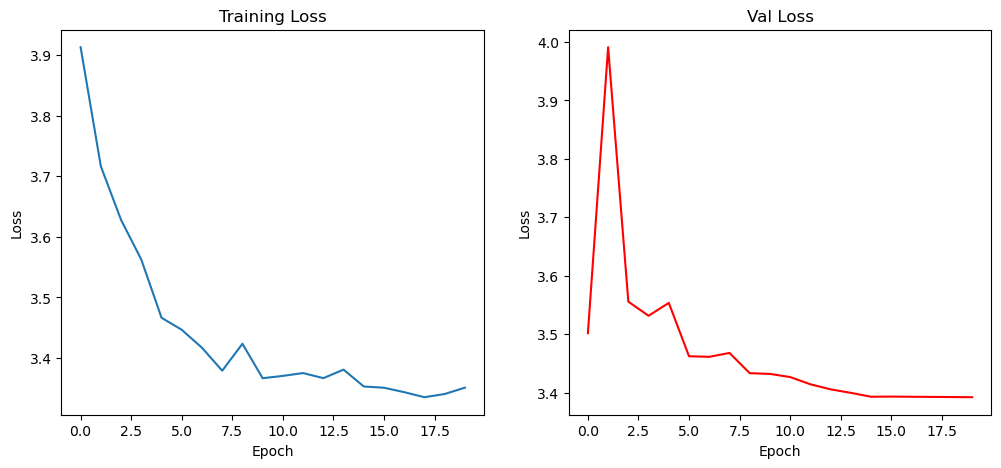

In [167]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(train_losses)
ax[0].set_title("Training Loss")
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(val_losses, color = 'red')
ax[1].set_title("Val Loss")
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

plt.show()

## 11. Evaluation

In [168]:
val_loss = evaluate(model, val_loader, criterion, device)
test_loss = evaluate(model, test_loader, criterion, device)

print("Val Loss: ", val_loss)
print("Test Loss: ", test_loss)

Val Loss:  3.3919442829332853
Test Loss:  3.4494715452194216


## 12. Make Predictions

In [193]:
def predict(model, img):
    model.eval()
    with torch.no_grad():
        outputs = model(img)
    return outputs

**Val dataset**

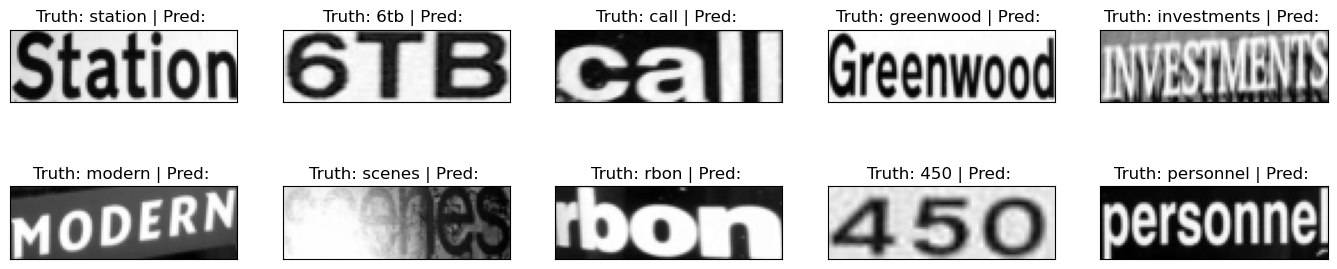

In [194]:
result = []

for i in range(10):
    idx = np.random.randint(len(val_dataset))
    img, label, label_len = val_dataset[idx]
    img = img.to(device)
    label = label.to(device)            
    label = decode([label], idx_to_char)[0]
    
    outputs = predict(model, img.unsqueeze(0))
    pred_text = decode(outputs.permute(1, 0, 2).argmax(2), idx_to_char)[0]
    result.append((img, label, pred_text))

fig = plt.figure(figsize = (17, 20))
for i in range(10):
    ax = fig.add_subplot(10, 5, i+1, xticks = [], yticks = [])
    
    img, label, pred_text = result[i]
    #img = img.cpu()
    title = f'Truth: {label} | Pred: {pred_text}'
    
    ax.imshow(img.permute(1, 2, 0), cmap = 'gray')
    ax.set_title(title)
plt.show()

**Test dataset**

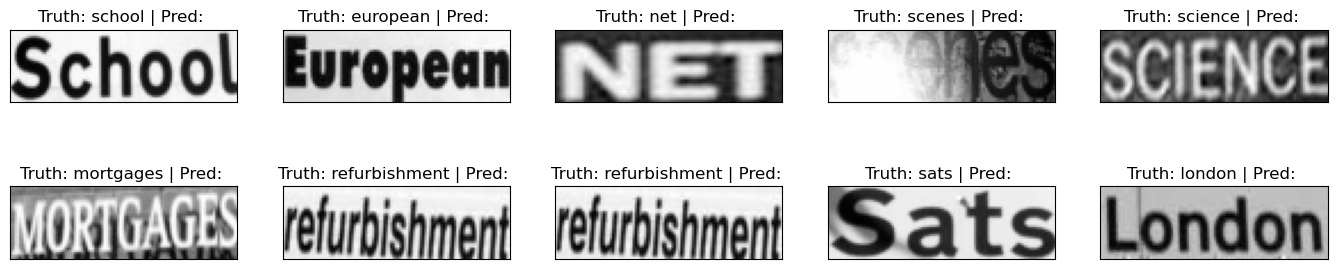

In [195]:
result = []

for i in range(10):
    idx = np.random.randint(len(test_dataset))
    img, label, label_len = test_dataset[idx]
    img = img.to(device)
    label = label.to(device)            
    label = decode([label], idx_to_char)[0]
    
    outputs = predict(model, img.unsqueeze(0))
    pred_text = decode(outputs.permute(1, 0, 2).argmax(2), idx_to_char)[0]
    
    result.append((img, label, pred_text))

fig = plt.figure(figsize = (17, 20))
for i in range(10):
    ax = fig.add_subplot(10, 5, i+1, xticks = [], yticks = [])
    
    img, label, pred_text = result[i]
    #img = img.cpu()
    title = f'Truth: {label} | Pred: {pred_text}'
    
    ax.imshow(img.permute(1, 2, 0), cmap = 'gray')
    ax.set_title(title)
plt.show()

## 13. Save model

In [196]:
save_model_path = "new_best.pt"
torch.save(model.state_dict(), save_model_path)